### Все файлы у нас лежат в zip, поэтому воспользуемся для начала пакетом, который поможет посмотреть, что в них находится.

In [1]:
# импортируем библиотеки
from zipfile import ZipFile
import datetime
from tqdm import tqdm
import math
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')

### Просмотр содержимого zip файла.

In [2]:
# смотрим какие размеры файлов в zip у нас есть
# также можно посмотреть, когда были изменения
zipfile = 'riiid-test-answer-prediction.zip'
with ZipFile(zipfile, mode='r') as archive:
    for info in tqdm(archive.infolist()):
        print(f"Filename: {info.filename}")
        print(f"Modified: {datetime.datetime(*info.date_time)}")
        print(f"Normal size: {info.file_size} bytes")
        print(f"Compressed size: {info.compress_size} bytes")
        print("-" * 20)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 753.96it/s]

Filename: questions.csv
Modified: 2020-10-14 17:45:04
Normal size: 296161 bytes
Compressed size: 80751 bytes
--------------------
Filename: train.csv
Modified: 2020-10-14 17:46:20
Normal size: 5846760913 bytes
Compressed size: 1349856793 bytes
--------------------
Filename: lectures.csv
Modified: 2020-10-14 17:45:04
Normal size: 9703 bytes
Compressed size: 2471 bytes
--------------------


In [3]:
# смотрим какие вообще файлы лежат в zip
archive = 'riiid-test-answer-prediction.zip'
zip_file = ZipFile(archive, mode='r')
[text_file.filename for text_file in zip_file.infolist()]

['questions.csv', 'train.csv', 'lectures.csv']

### Нам понадобятся 3 файла:
- train.csv;
- questions.csv;
- lectures.csv.

# Описание данных

## train.csv

- `row_id`: (int64) ИД строки.
- `timestamp`: (int64) время в миллисекундах между этим взаимодействием с пользователем и первым завершением события от этого пользователя.
- `user_id`: (int32) ИД пользователя.
- `content_id`: (int16) ИД для взаимодействия с пользователем
- `content_type_id`: (int8) 0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр пользователем лекции.
- `task_container_id`: (int16) ИД для пакета вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидит пояснения к любому из них. Все эти трое будут иметь общий идентификатор task_container_id.
- `user_answer`: (int8) ответ пользователя на вопрос, если он есть. Прочитайте -1 как ноль, для лекций.
- `answered_correctly`: (int8) если пользователь ответил правильно. Прочитайте -1 как ноль, для лекций.
- `prior_question_elapsed_time`: (float32) Среднее время в миллисекундах, затрачиваемое пользователем на ответ на каждый вопрос из предыдущей группы вопросов, без учета промежуточных лекций. Имеет значение null для первого набора вопросов пользователя или лекции. Обратите внимание, что время — это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем наборе.
- `prior_question_had_explanation`: (bool) Независимо от того, видел ли пользователь объяснение и правильный ответ после ответа на предыдущий пакет вопросов, игнорируя любые промежуточные лекции. Это значение является общим для одного пакета вопросов и равно нулю для первого пакета вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, были частью диагностического теста на борту, где они не получали никакой обратной связи.

## questions.csv: метаданные для вопросов, заданных пользователям.

- `question_id`:внешний ключ для столбца content_id, когда тип содержимого — вопрос (0).
- `bundle_id`: код, для которого вопросы подаются вместе.
- `correct_answer`: ответ на вопрос. Можно сравнить со столбцом train user_answer, чтобы проверить, был ли пользователь прав.
- `part`:соответствующий раздел теста TOEIC.
- `tags`: один или несколько подробных кодов тегов для вопроса. Значение тегов не будет предоставлено, но этих кодов достаточно дл

## lectures.csv: метаданные для лекций, просмотренных пользователями по мере их обучения.

- `lectures.csv`: метаданные для лекций, просмотренных пользователями по мере их обучения.
- `lecture_id`: внешний ключ для столбца content_id, когда тип контента — лекция (1).
- `part`: код категории верхнего уровня для лекции.
- `tag`: один код тега для лекции. Значение тегов не будет предоставлено, но этих кодов достаточно для группировки лекций.
- `type_of`: краткое описание основной цели лекции

### Формируем DataFrames

In [4]:
# train.csv
# файл огромный, сократим его до считывания 10-20% строк
dtypes = {'row_id': 'int64'  
          ,'timestamp': 'int64'  
          ,'user_id': 'int64'  
          ,'content_id': 'int64'  
          ,'content_type_id': 'int64'  
          ,'task_container_id': 'int64'  
          ,'user_answer': 'int64'  
          ,'answered_correctly': 'int64'  
          ,'prior_question_elapsed_time': 'float64'
          ,'prior_question_had_explanation': 'object' 
         }
p = 0.1
random.seed(11)
df_train = pd.read_csv(ZipFile(zipfile, mode='r').open('train.csv') 
                                                       ,dtype=dtypes
                                                       ,header=0
                                                       ,skiprows=lambda i: i>0 and random.random()>p)
df_train.head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,10,255381,115,152,0,10,2,0,17000.0,False
1,12,302994,115,108,0,12,1,0,23000.0,False


In [5]:
# questions.csv

df_questions = pd.read_csv(ZipFile(zipfile, mode='r').open('questions.csv'))
df_questions.head(3)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92


In [6]:
# lectures

df_lectures = pd.read_csv(ZipFile(zipfile, mode='r').open('lectures.csv'))
df_lectures.head(3)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept


### Приступаем к анализу данных.

In [7]:
# узнаем какие типы данных у нас есть
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10123715 entries, 0 to 10123714
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 772.4+ MB


In [8]:
# чтобы наши колонки соответствовали типам 
# , заявленным в описании, преобразуем их.
df_train['user_id'] = df_train['user_id'].astype('int32')
df_train['content_id'] = df_train['content_id'].astype('int16')
df_train['content_type_id'] = df_train['content_type_id'].astype('int8')
df_train['task_container_id'] = df_train['task_container_id'].astype('int16')
df_train['user_answer'] = df_train['user_answer'].astype('int8')
df_train['answered_correctly'] = df_train['answered_correctly'].astype('int8')
df_train['prior_question_elapsed_time'] = df_train['prior_question_elapsed_time'].astype('float32')
df_train['prior_question_had_explanation'] = df_train['prior_question_had_explanation'].astype('bool')

In [9]:
# посмотрим сколько всего пропусков по всем столбцам.
# составим процентный список пропущенных значений
for col in tqdm(df_train.columns):
    pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.36it/s]

row_id - 0%
timestamp - 0%
user_id - 0%
content_id - 0%
content_type_id - 0%
task_container_id - 0%
user_answer - 0%
answered_correctly - 0%
prior_question_elapsed_time - 2%
prior_question_had_explanation - 0%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.58it/s]


created missing indicator for: prior_question_elapsed_time


<AxesSubplot:xlabel='index'>

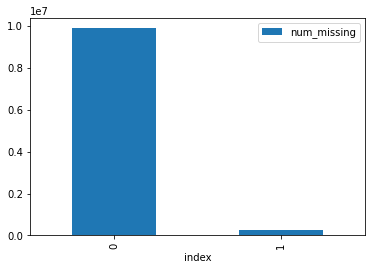

In [10]:
# также можно построить гистограмму пропущенных значений
# сначала создаем индикатор для признаков с пропущенными данными
for col in tqdm(df_train.columns):
    missing = df_train[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df_train['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df_train.columns if 'ismissing' in col]
df_train['num_missing'] = df_train[ismissing_cols].sum(axis=1)

df_train['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

Исходя из целей анализа, с пропущенными значениями нужно было бы что-то делать. Так как пропущенных значений всего 2%, как правило, в таких случаях заменяют пропущенное значение на нужный показатель, обычно берут средней или медиану для устранения пропусков в данных. При этом, пропуски у нас содержаться в столбце "среднее время, затрачиваемое пользователем на ответ на каждый вопрос из предыдущей группы вопросов, без учета промежуточных лекций". Можем предположить, что студент не отвечал на вопрос и не тратил на него время. При таком подходе, будет целесообразно заменить пропущенное значение на "0".

In [11]:
df_train["prior_question_elapsed_time"].fillna(0, inplace = True)
df_train.isnull().sum()

row_id                                   0
timestamp                                0
user_id                                  0
content_id                               0
content_type_id                          0
task_container_id                        0
user_answer                              0
answered_correctly                       0
prior_question_elapsed_time              0
prior_question_had_explanation           0
prior_question_elapsed_time_ismissing    0
num_missing                              0
dtype: int64

In [12]:
# #смотрим на распределение всех признаков
# spec = mpl.gridspec.GridSpec(
# ncols=3, nrows=20, height_ratios=[1, 4] * 10, hspace = 0.55
# )

# fig=plt.figure(figsize=(18, 60))

# for i in range(5):
#     for j in range(3):
#         ax=fig.add_subplot(spec[6*i+j])
#         sns.boxplot(data=df_train,
#                    x=df_train.columns[3*i+j],
#                    palette='Set2', 
#                    ax=ax).set(xlabel=None)
        
#         ax=fig.add_subplot(spec[6*i+j+3])
#         sns.histplot(data=df_train,
#                    x=df_train.columns[3*i+j],
#                    kde=True, ax=ax, stat='probability',
#                    palette='Set2').set(ylabel=None)
# plt.show()

In [13]:
df_train.columns.value_counts()

row_id                                   1
timestamp                                1
user_id                                  1
content_id                               1
content_type_id                          1
task_container_id                        1
user_answer                              1
answered_correctly                       1
prior_question_elapsed_time              1
prior_question_had_explanation           1
prior_question_elapsed_time_ismissing    1
num_missing                              1
dtype: int64

In [14]:
df_train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,num_missing
count,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07,1.012372e+07
mean,5.061338e+07,7.712918e+09,1.076694e+09,5.218660e+03,1.935278e-02,9.041588e+02,1.376556e+00,6.252328e-01,2.467163e+04,2.324344e-02
std,2.922128e+07,1.161042e+10,6.196857e+08,3.865564e+03,1.377616e-01,1.358494e+03,1.192968e+00,5.225154e-01,1.982988e+04,1.506758e-01
min,1.000000e+01,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,2.531415e+07,5.243064e+08,5.409521e+08,2.063000e+03,0.000000e+00,1.050000e+02,0.000000e+00,0.000000e+00,1.500000e+04,0.000000e+00
50%,5.060441e+07,2.674357e+09,1.071654e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04,0.000000e+00
75%,7.591964e+07,9.928486e+09,1.615726e+09,7.425000e+03,0.000000e+00,1.093000e+03,3.000000e+00,1.000000e+00,2.900000e+04,0.000000e+00
max,1.012303e+08,8.719328e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05,1.000000e+00


### Посмотрим, есть ли в данных выбросы или аномалии.

In [15]:
# #строим для этого боксплоты для каждой нашей фичи.
# sns.boxplot(data=df_train);

In [16]:
# # Также можно посмотреть как именно распределены наши данные
# sns.kdeplot(data=df_train);

In [17]:
columns = df_train.columns

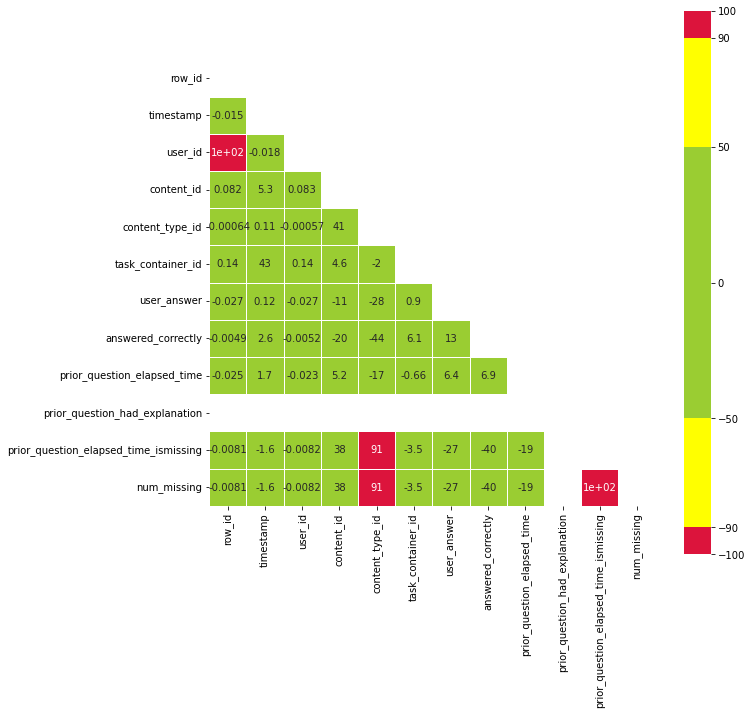

In [18]:
# В конце еще посмотрим на матрицу корреляций наших фичей
cmatrix = df_train[columns].corr() * 100
    
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'yellow', 'yellow', 'yellow',
                                                             'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen',
                                                             'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen',
                                                             'yellow', 'yellow', 'yellow', 'yellow', 'crimson'], 20)

mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(ax=ax, data=cmatrix, cmap=cmap, 
                vmin=-100, vmax=100, linewidths=.5, 
                square=True, annot=True, 
                mask=mask, annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-100, -90, -50, 0, 50, 90, 100])
plt.show()

### Можно посмотреть на 15 самых активных студентов.

In [19]:
users = df_train["user_id"].value_counts().reset_index()
users.columns = ["user_id", "actions_count"]


users_top_15 = users.head(15)
users_top_15

,user_id,actions_count
0,801103753,1823
1,455973631,1731
2,1743444187,1671
3,2146130037,1670
4,1842816145,1645
5,1660941992,1615
6,870330384,1614
7,1547278749,1610
8,338684437,1604
9,1047202059,1604


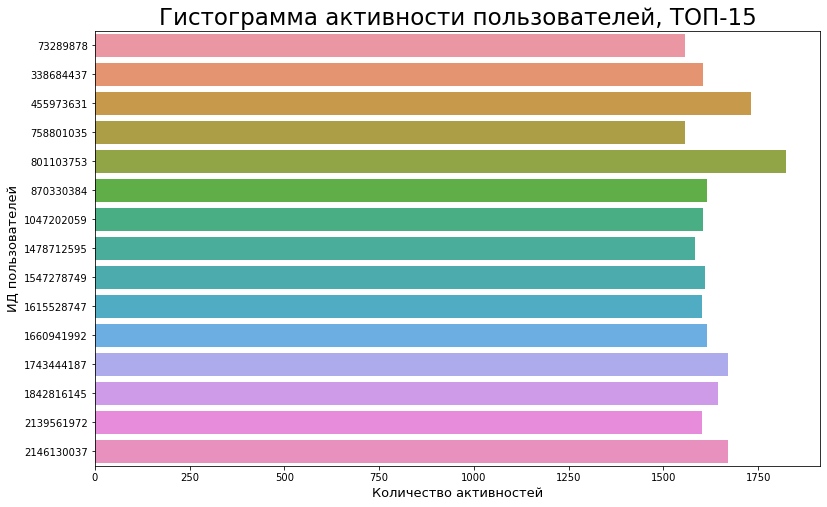

In [20]:
#построим гистограмму
fig = plt.figure(figsize=(13,8))
x = users_top_15["actions_count"]
y = users_top_15["user_id"]
sns.barplot(data=users_top_15, x = x, y = y, orient="h")
plt.title("Гистограмма активности пользователей, ТОП-15", fontsize=23)
plt.xlabel("Количество активностей", fontsize=13)
plt.ylabel("ИД пользователей", fontsize=13)
plt.show()

In [21]:
# сколько студентов забросило учебу
drop = users[users.actions_count == 1].shape[0]
percent = users[users.actions_count == 1].shape[0] / users.shape[0] * 100
percent = round(percent, 2)
print(f'Колличество студентов, забросивших учебу: {drop}, что составляет {percent}%')

Колличество студентов, забросивших учебу: 40778, что составляет 10.89%


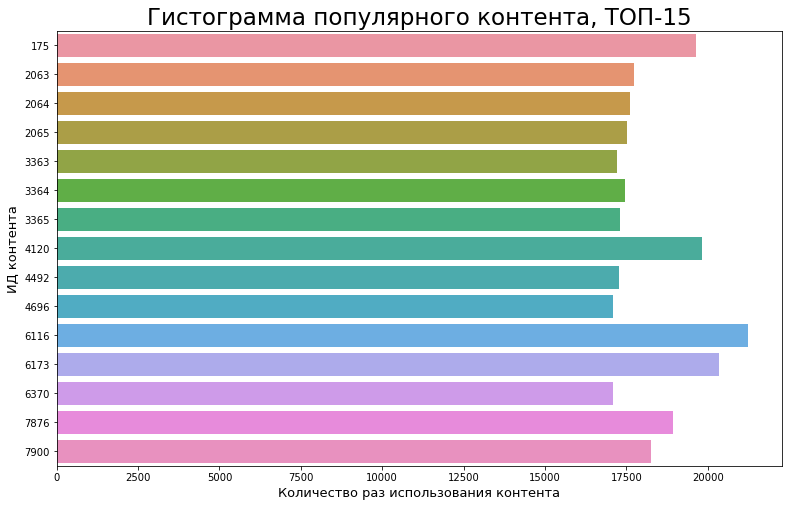

In [22]:
# также посмотрим на популярный контент
content = df_train["content_id"].value_counts().reset_index()
content.columns = ["content_id", "content_count"]
content_top_15 = content.head(15)

fig = plt.figure(figsize=(13,8))
x = content_top_15["content_count"]
y = content_top_15["content_id"]
sns.barplot(data=content_top_15, x = x, y = y, orient="h")
plt.title("Гистограмма популярного контента, ТОП-15", fontsize=23)
plt.xlabel("Количество раз использования контента", fontsize=13)
plt.ylabel("ИД контента", fontsize=13)
plt.show()

In [23]:
# посмотрим как отвечали пользователи
content_df = df_train[df_train.answered_correctly != -1].groupby('content_id').agg(
    {'answered_correctly': ['count', 'mean']}
).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']
content_df

,content_id,content_questions,content_mean
0,0,648,0.896605
1,1,728,0.894231
2,2,4493,0.550634
3,3,2339,0.775545
4,4,3164,0.609671
...,...,...,...
13502,13518,104,0.846154
13503,13519,89,0.539326
13504,13520,77,0.636364
13505,13521,76,0.776316


In [24]:
# посмотрим на распределение контента 
content_type = df_train["content_type_id"].value_counts().reset_index()
content_type.columns = ["content_type", "content_count"]
content_type

,content_type,content_count
0,0,9927793
1,1,195922


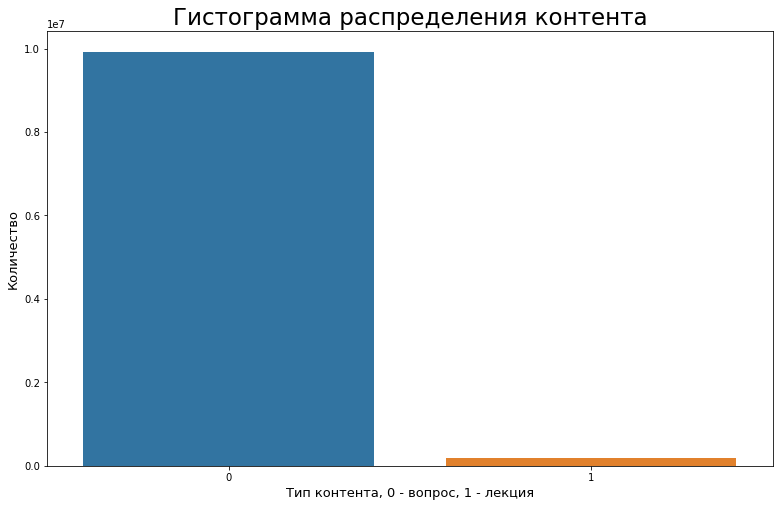

In [25]:
fig = plt.figure(figsize=(13,8))
x = "content_type"
y = "content_count"
sns.barplot(data=content_type, x = x, y = y)
plt.title("Гистограмма распределения контента", fontsize=23)
plt.xlabel("Тип контента, 0 - вопрос, 1 - лекция", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()

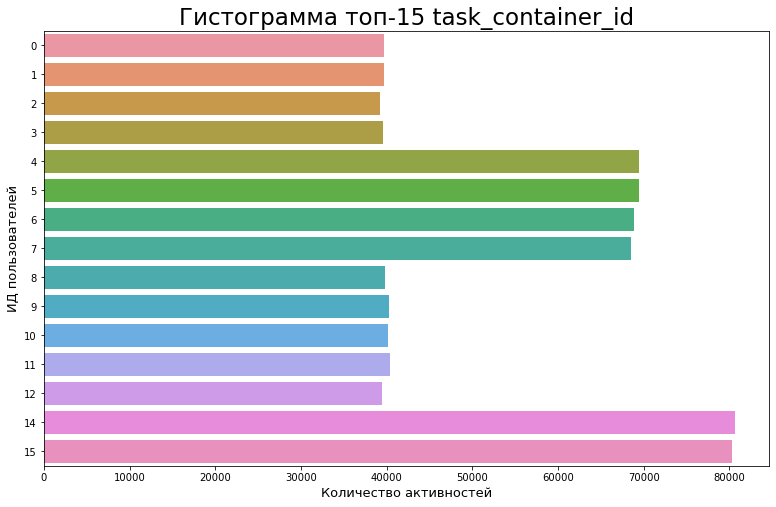

In [26]:
# смотрим на топ task_container_id
task_container_id = df_train["task_container_id"].value_counts().reset_index()
task_container_id.columns = ["task_container_id", "task_container_count"]
task_container_id_top_15 = task_container_id.head(15)

fig = plt.figure(figsize=(13,8))
x = "task_container_count"
y = "task_container_id"
sns.barplot(data=task_container_id_top_15, x = x, y = y, orient="h")
plt.title("Гистограмма топ-15 task_container_id", fontsize=23)
plt.xlabel("Количество активностей", fontsize=13)
plt.ylabel("ИД пользователей", fontsize=13)
plt.show()

In [27]:
# смотрим на ответы пользователей.
user_answer = df_train["user_answer"].value_counts().reset_index()
user_answer.columns = ["user_answer", "user_answer_count"]
user_answer

,user_answer,user_answer_count
0,0,2817481
1,1,2699153
2,3,2610314
3,2,1800845
4,-1,195922


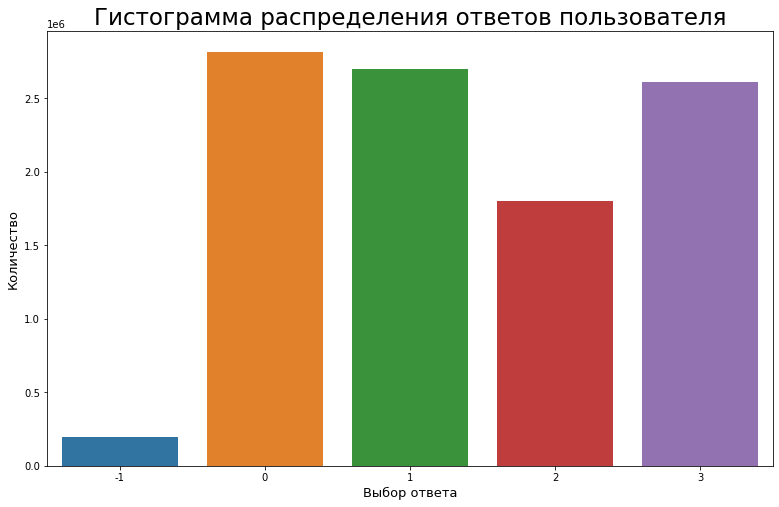

In [28]:
#строим гистограмму распределение ответов пользователя
fig = plt.figure(figsize=(13,8))
x = "user_answer"
y = "user_answer_count"
sns.barplot(data=user_answer, x = x, y = y)
plt.title("Гистограмма распределения ответов пользователя", fontsize=23)
plt.xlabel("Выбор ответа", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()

Мы видим, что чаще всего пользователи выбирали ответы 0 и 1, реже всего -1.

In [29]:
# посмотрим на процент
user_answer1 = df_train["user_answer"].value_counts(normalize=True).reset_index()
user_answer1.columns = ["user_answer", "user_answer_persent"]
user_answer1

,user_answer,user_answer_persent
0,0,0.278305
1,1,0.266617
2,3,0.257842
3,2,0.177884
4,-1,0.019353


In [30]:
user_percents = df_train[df_train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Максимальное количество вопросов на которые ответил пользователь {user_percents.Answers.max()}')

Максимальное количество вопросов на которые ответил пользователь 1797


### Теперь посмотрим на среднее время затраченное пользователем на ответ.

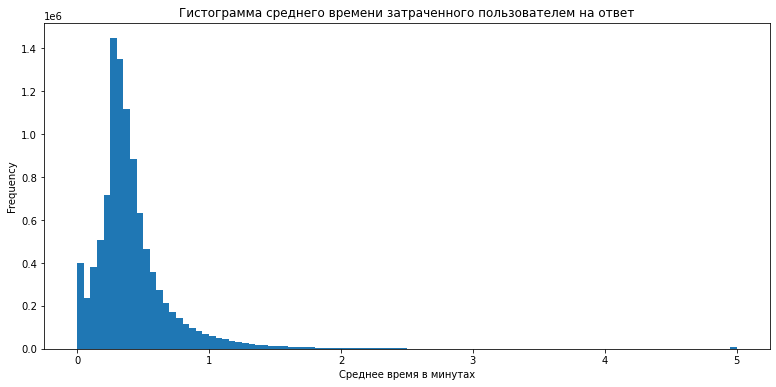

In [31]:
fig = plt.figure(figsize=(13,6))
(df_train["prior_question_elapsed_time"] / 60000).plot.hist(bins=100)
plt.title("Гистограмма среднего времени затраченного пользователем на ответ")
plt.xticks(rotation=0)
plt.xlabel("Среднее время в минутах")
plt.show()

Из гистограммы следует, что чаще всего ответ дается в первую минуту

In [32]:
# последнее на что смотрм - это prior_question_had_explanation
prior_question_had_explanation = df_train["prior_question_had_explanation"].value_counts().reset_index()
prior_question_had_explanation

,index,prior_question_had_explanation
0,True,10123715


### Переходим к анализу датасета questions

In [33]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [34]:
df_questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


<AxesSubplot:>

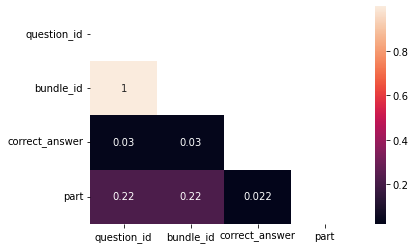

In [35]:
# построим матрицу корреляций
# в привычном нам виде.

matrix = np.triu(df_questions.corr())
sns.heatmap(df_questions.corr(), annot=True, mask=matrix)

Фичи `question_id` и `bundle_id` дублируют друг друга.

In [36]:
# создадим новый столбец с количеством тегов вопросов
df_questions['tag'] = df_questions['tags'].str.split(' ')
df_questions = df_questions.explode('tag')
df_questions = pd.merge(df_questions, df_questions.groupby('question_id')['tag'].count().reset_index(), on='question_id')

df_questions = df_questions.drop(['tag_x'], axis=1)

df_questions.columns = [
    'question_id', 
    'bundle_id', 
    'correct_answer', 
    'part', 
    'tags', 
    'tags_number'
]

In [37]:
# дропаем дубликаты
df_questions = df_questions.drop_duplicates() 
df_questions.head(2)

,question_id,bundle_id,correct_answer,part,tags,tags_number
0,0,0,0,1,51 131 162 38,4
4,1,1,1,1,131 36 81,3


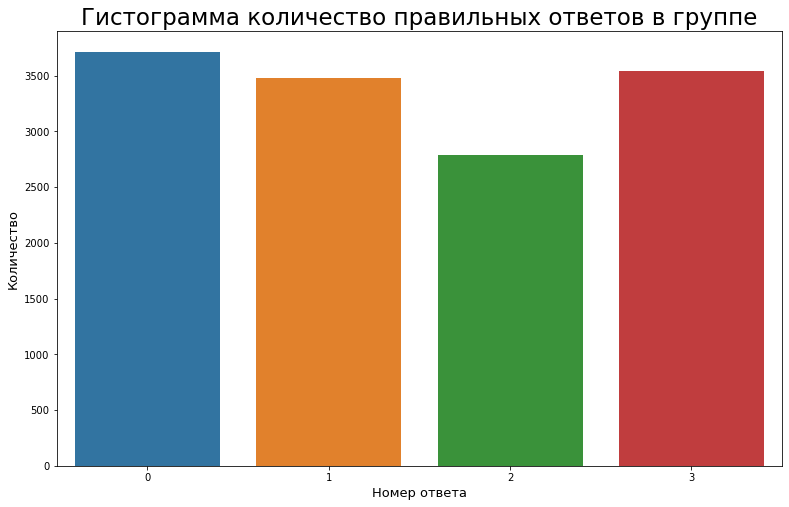

In [38]:
# количество правильных ответов в группе.
correct_answer = df_questions["correct_answer"].value_counts().reset_index()
correct_answer.columns = ["correct_answer", "number_of_answers"]

fig = plt.figure(figsize=(13,8))
x = "correct_answer"
y = "number_of_answers"
sns.barplot(data=correct_answer, x = x, y = y)
plt.title("Гистограмма количество правильных ответов в группе", fontsize=23)
plt.xlabel("Номер ответа", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()


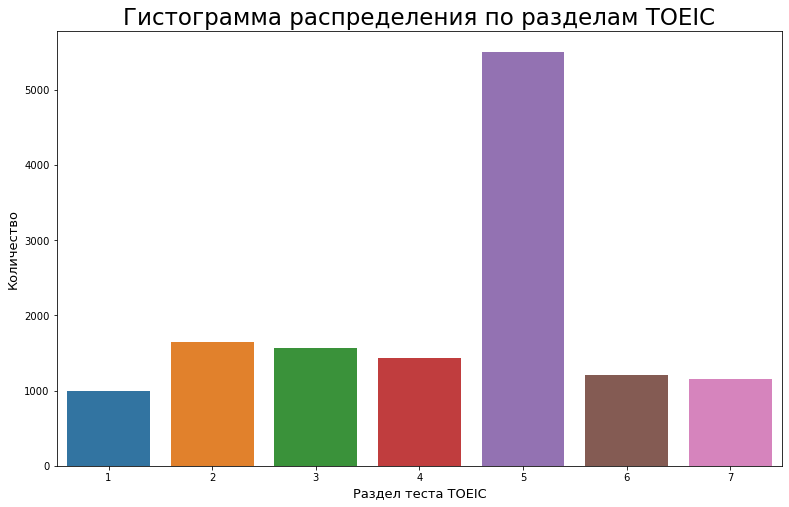

In [39]:
# распределение по TOEIC
part = df_questions["part"].value_counts().reset_index()
part.columns = ["part", "count"]

fig = plt.figure(figsize=(13,8))
x = "part"
y = "count"
sns.barplot(data=part, x = x, y = y)
plt.title("Гистограмма распределения по разделам TOEIC", fontsize=23)
plt.xlabel("Раздел теста TOEIC", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()

Чаще всего использовались тесты 5 раздела, реже 1 раздела.

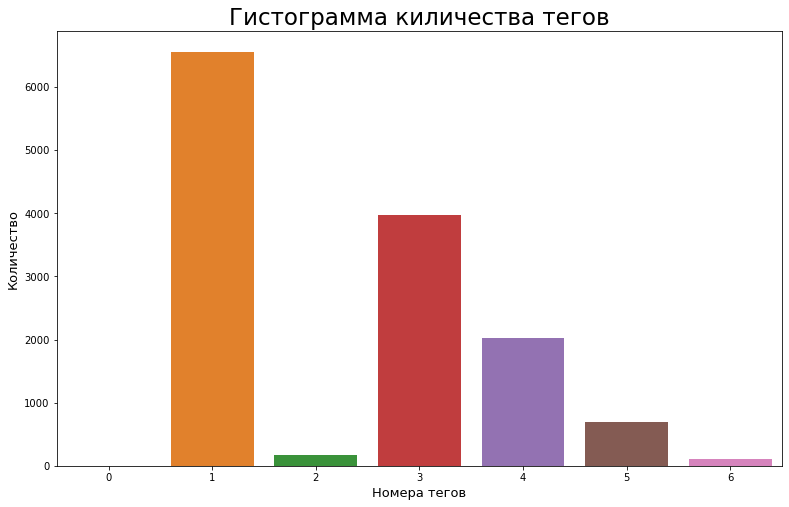

In [40]:
# смотрим на количество тегов
tags_number = df_questions["tags_number"].value_counts().reset_index()
tags_number.columns = ["tags_number", "count"]

fig = plt.figure(figsize=(13,8))
x = "tags_number"
y = "count"
sns.barplot(data=tags_number, x = x, y = y)
plt.title("Гистограмма киличества тегов", fontsize=23)
plt.xlabel("Номера тегов", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()

### Переходим к анализу датасета lectures

In [41]:
df_lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [42]:
df_lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


<AxesSubplot:>

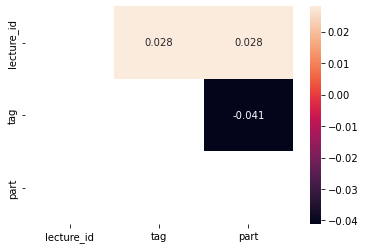

In [43]:
mask = np.tril(df_lectures.corr())
sns.heatmap(df_lectures.corr(), annot=True, mask=mask)

In [44]:
# проверим дубликаты
df_lectures.duplicated().sum()

0

In [45]:
# посмотрим признак tag
lectures_tag = df_lectures["tag"].value_counts().reset_index()
lectures_tag.columns = ["tag", "count"]
lectures_tag

,tag,count
0,136,7
1,27,6
2,161,6
3,74,6
4,134,6
...,...,...
146,90,1
147,112,1
148,31,1
149,138,1


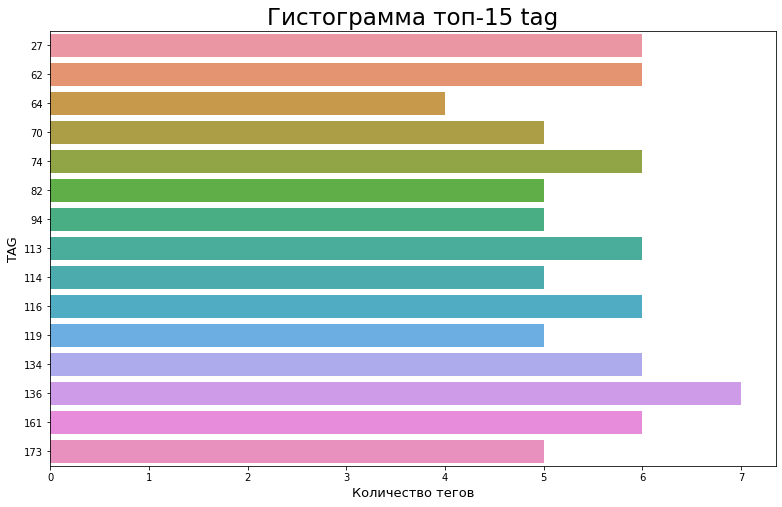

In [46]:
# строим топ-15 tag
lectures_tag_top_15 = lectures_tag.head(15)
fig = plt.figure(figsize=(13,8))
x = "count"
y = "tag"
sns.barplot(data=lectures_tag_top_15, x = x, y = y, orient="h")
plt.title("Гистограмма топ-15 tag", fontsize=23)
plt.xlabel("Количество тегов", fontsize=13)
plt.ylabel("TAG", fontsize=13)
plt.show()

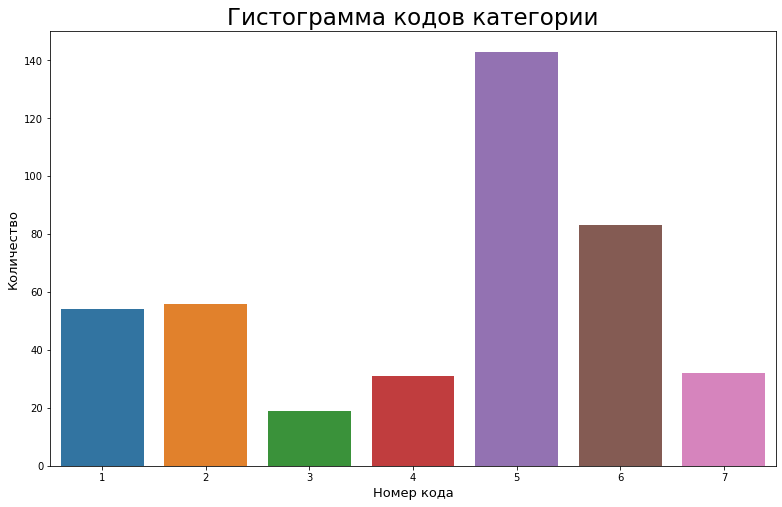

In [48]:
# строим гистограмму фичи part
lectures_part = df_lectures["part"].value_counts().reset_index()
lectures_part.columns = ["part", "count"]

fig = plt.figure(figsize=(13,8))
x = "part"
y = "count"
sns.barplot(data=lectures_part, x = x, y = y)
plt.title("Гистограмма кодов категории", fontsize=23)
plt.xlabel("Номер кода", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()

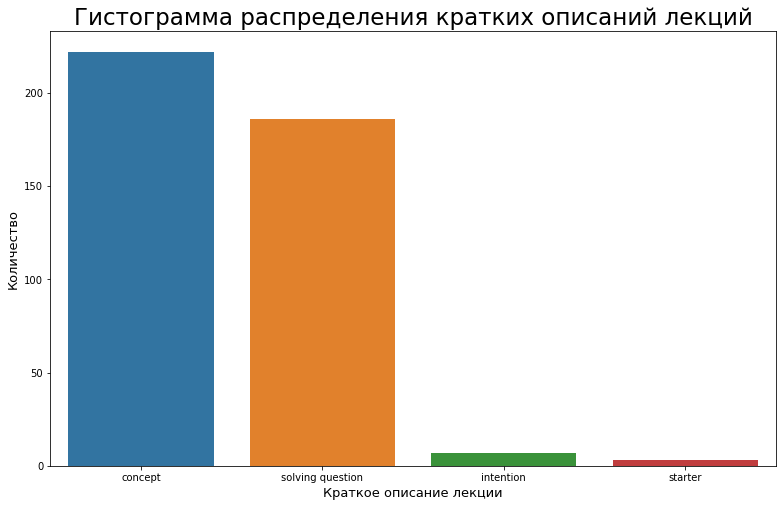

In [49]:
# строим последнюю гистограмму type_of
lectures_type_of = df_lectures["type_of"].value_counts().reset_index()
lectures_type_of.columns = ["type_of", "count"]

fig = plt.figure(figsize=(13,8))
x = "type_of"
y = "count"
sns.barplot(data=lectures_type_of, x = x, y = y)
plt.title("Гистограмма распределения кратких описаний лекций", fontsize=23)
plt.xlabel("Краткое описание лекции", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.show()